#### *Run this cell to resolve import issues*

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Please Ignore All The Comments

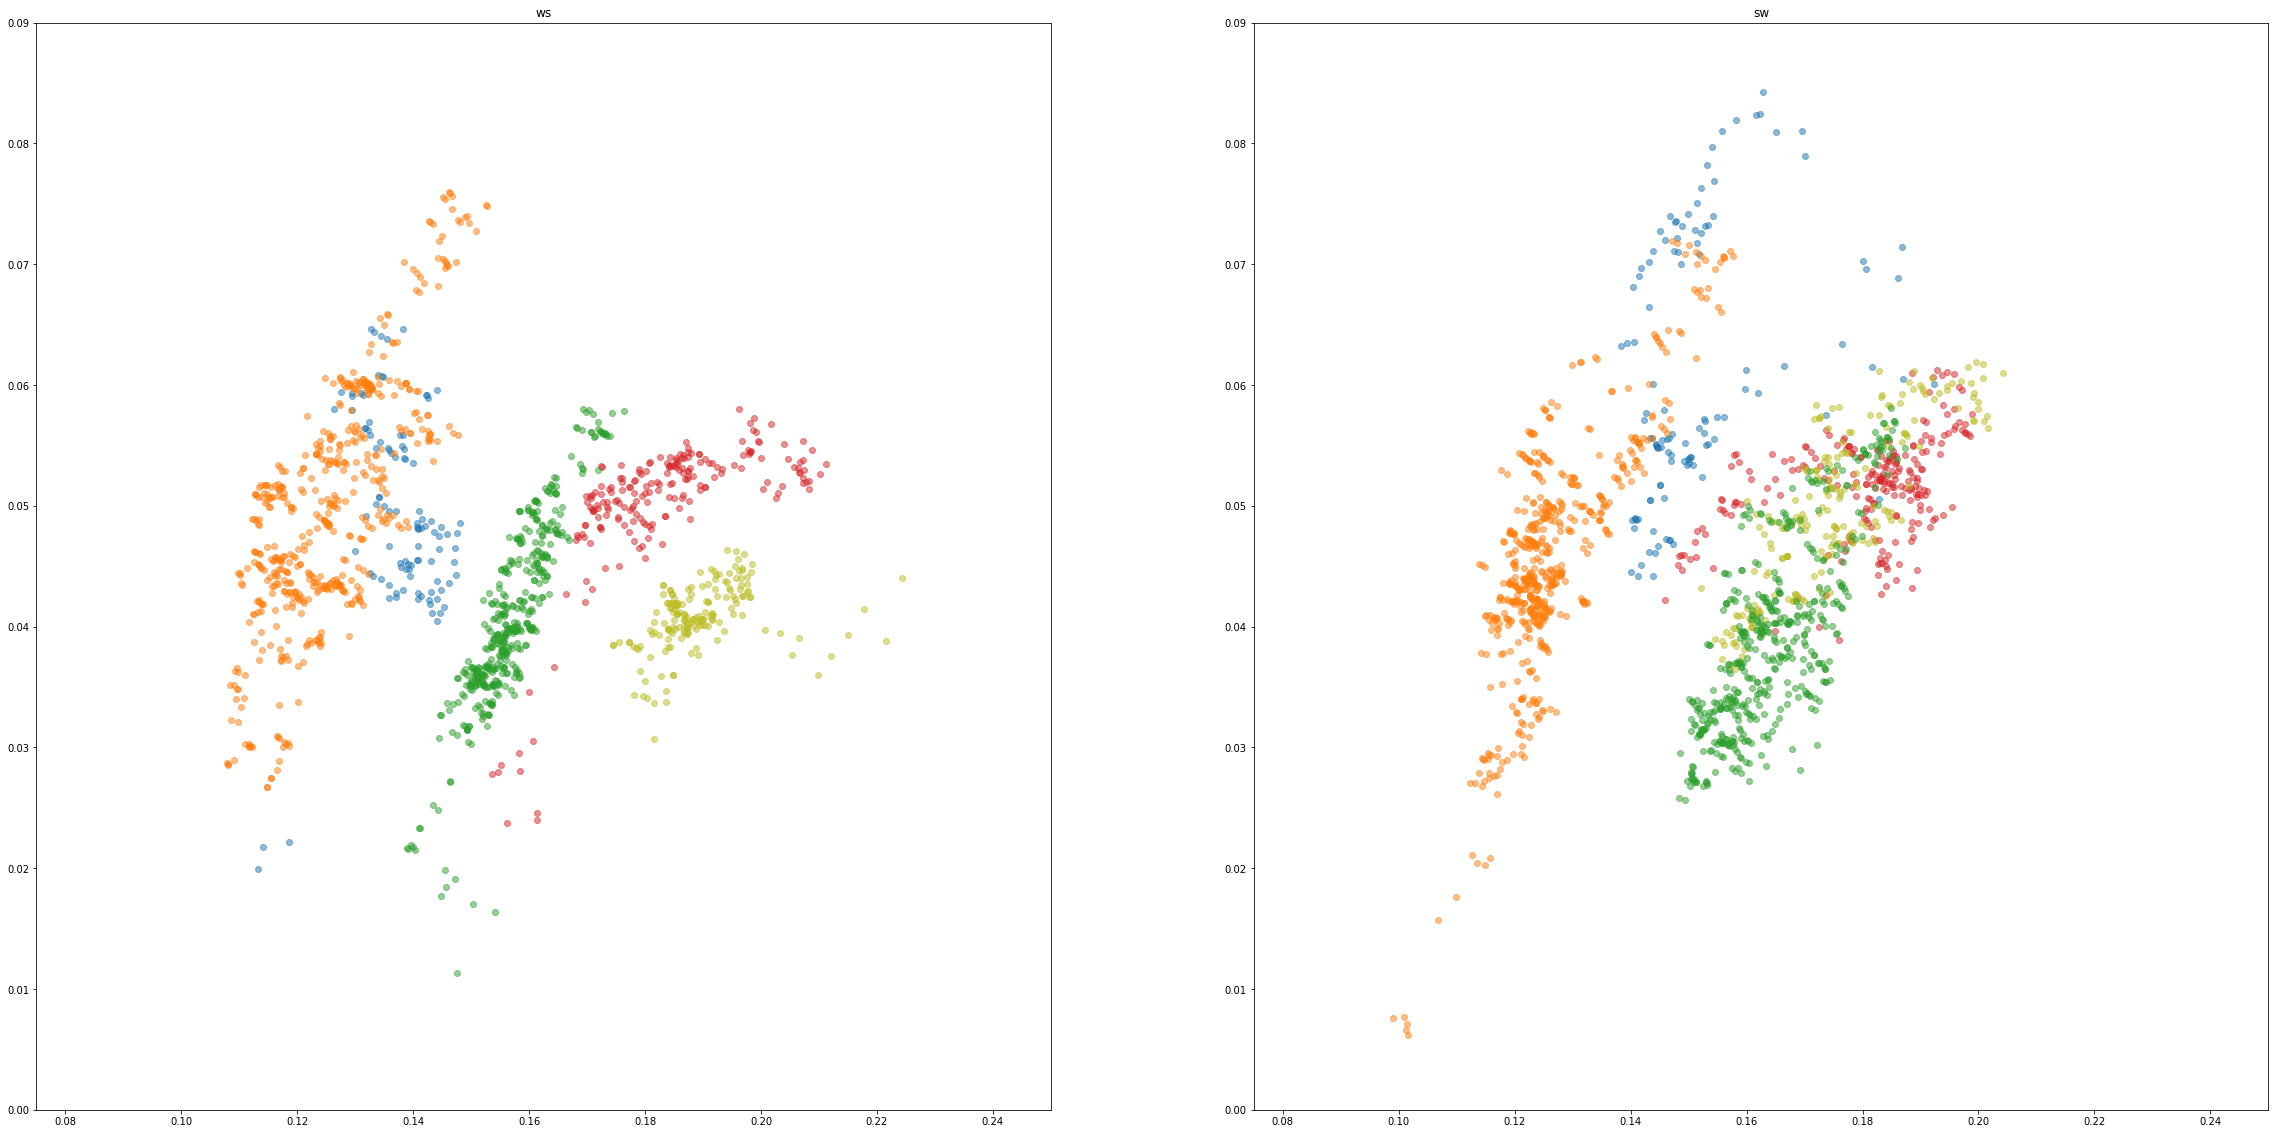

In [2]:
%matplotlib inline
from log_parser import parse_keyboard_log
from log_parser import extract_predefined_patterns
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from log_parser import parse_keyboard_log
from numpy_ringbuffer import RingBuffer

sample_size = 40
labels = ['HEN', 'ZIR', 'JOS', 'MAR', 'MIT'] # Left out Jon bc he has no SOL logfile
# Also I should just change this to use the routing file but it is what it is

# Creates 4 subplots
fig, ax = plt.subplots(1, 2, figsize=(40, 20))

predefined_patterns = {'w':['s','q','1'], 's':['w'], 'd':['f'], 'f':['d'], 'q':['a','w'], 'a':['q'], '1':['w']}
for name in labels: # For each name listed above:

    # Convert the logfile to a DataFrame
    kb = parse_keyboard_log(f"../logs/{name}/SOL/key.log")


    # Temperory dictionaries used to stire the most recent press or release for keys in the predefined_patterns
    tempPressDict = {}
    tempReleaseDict = {}
    # The result dictionary used to store the average/highest/shortest duration for the key release-press pairs in the predefined_patterns
    # The result should have the following format:  'resultKey':[totalDuration, freq, longestDuration, shortestDuration, averageDuration]
    durations_dict = {}
    duration_data = {}
    #Find the key release-press pairs and calculate duration and freq for each pair, and re
    for _, row in kb.iterrows():
        # Extract keyname (remove surrounding '' if needed)
        key = row['key']
        key = key.replace("'", "")

        if key in predefined_patterns:
            # Get the time and the action for this row
            time = float(row['time'])
            action = row['action']

            if action == 'pressed': # if it is the press of a release-press pair
                # Update the time in tempPressDict
                tempPressDict[key] = time
                # Check for the release-press pair
                for pairedKey in predefined_patterns[key]:# check release-press pair for all paired keys for this key
                    if pairedKey in tempReleaseDict:# if we have the data for the required key release 
                        # Validate a release-press pair by 2 metrics: 1. press time < release time. 2. (press time - release time) < 0.3 second
                        if tempReleaseDict[pairedKey] < time and time - tempReleaseDict[pairedKey] <= 0.3:
                            curr_duration = time - tempReleaseDict[pairedKey]# calculate duration for this release-press pair
                            resultKey = key + pairedKey # compute resultKey
                            if resultKey in durations_dict:# if it's not the first record for resultKey
                                # update total duration and freq
                                durations_dict[resultKey].append(curr_duration)
                                durations_np = np.array(durations_dict[resultKey]) # Convert to numpy array
                                if durations_np.size > 3:
                                    duration_data[resultKey][0].append((durations_np.mean(), durations_np.std()))
                                    duration_data[resultKey][1].append('Hengjun')
                            else:# if it is the first record for resultKey
                                durations_dict[resultKey] = RingBuffer(capacity=sample_size, dtype=float)
                                duration_data[resultKey] = [[], []]
            else: # if it is the release of a release-press pair
                tempReleaseDict[key] = time # Update the time in tempReleaseDict

    # I got pretty lazy here but it works lol
    color = 'black'
    if name == 'HEN':
        color = 'tab:blue'
    if name == 'ZIR':
        color = 'tab:red'
    if name == 'JOS':
        color = 'tab:olive'
    if name == 'MAR':
        color = 'tab:green'
    if name == 'MIT':
        color = 'tab:orange'
    if name == 'JON':
        color = 'tab:purple'

    # Each call to scatter() on the same axes just draws more points on top of it
    ax[0].set_title('ws')
    ax[0].set_xlim(0.075, 0.25)
    ax[0].set_ylim(0.00, 0.09)
    ax[0].scatter([x for x, _ in duration_data['ws'][0]], [y for _, y in duration_data['ws'][0]], c=color, alpha=0.5)

    ax[1].set_title('sw')
    ax[1].set_xlim(0.075, 0.25)
    ax[1].set_ylim(0.00, 0.09)
    ax[1].scatter([x for x, _ in duration_data['sw'][0]], [y for _, y in duration_data['sw'][0]], c=color, alpha=0.5)

target:MAR
Soft Train score: 1.0 Soft Test score: 0.8472727272727273
RF + ANN Hard Train score: 1.0 RF + ANN Hard Test score: 0.88
RFC Train score: 1.0 RFC Test score: 0.8654545454545455
KNN Train score: 0.7359477124183007 KNN Test score: 0.6363636363636364
ANN Train score: 1.0 ANN Test score: 0.8436363636363636
NB Train score: 0.4954248366013072 NB Test score: 0.4618181818181818


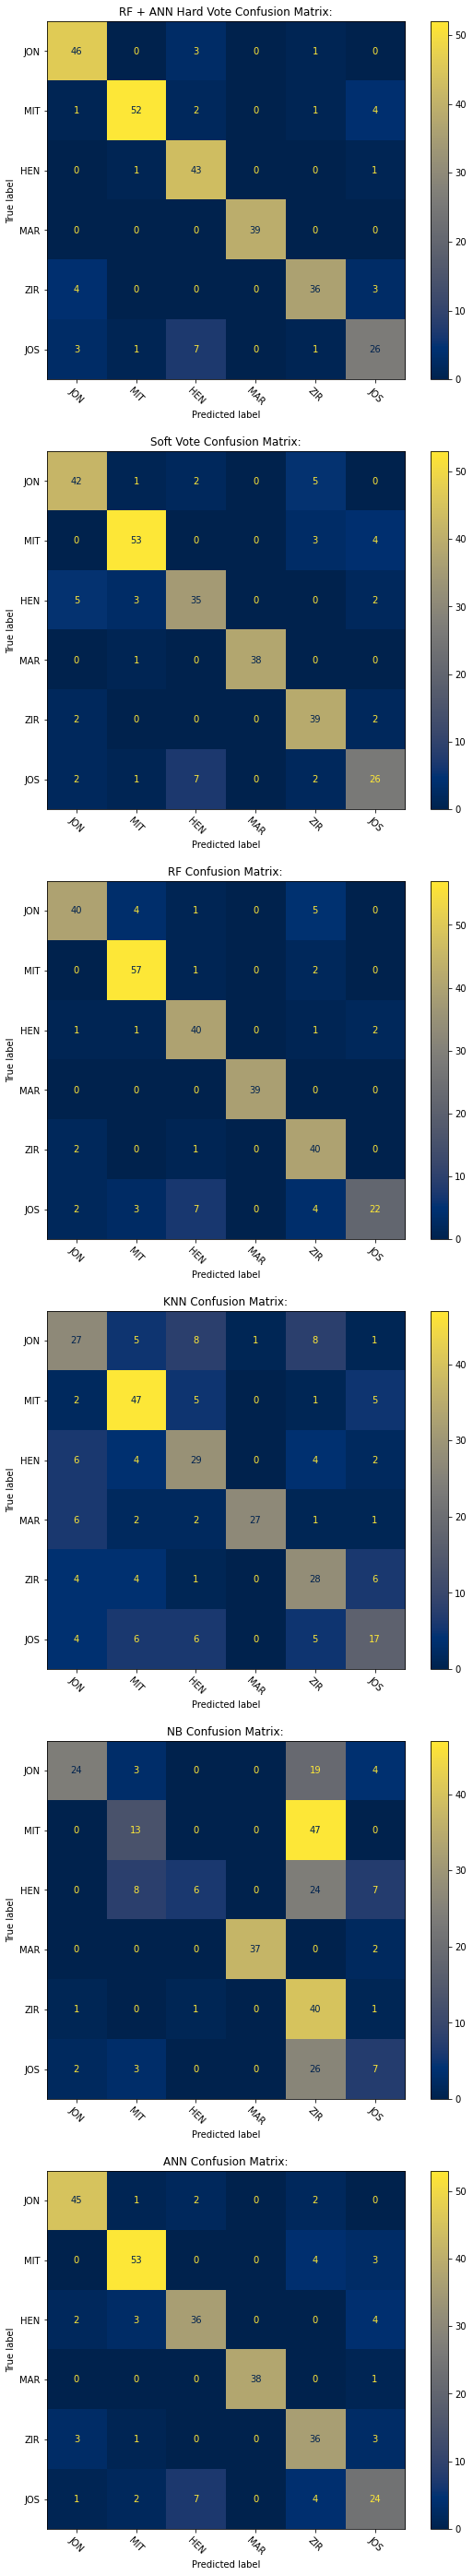

In [2]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


# Set to false to test non-binary classification
test_binary = False

# Set to false for regular sampling
undersampling = True

# List of parsed logfiles
keyboard = []
mouse = []

# Read logfile paths from .routing
with open("../.routing", 'r', encoding='utf-8') as f:
    log_paths = f.read().splitlines()   # Read lines without '\n's
    for path in log_paths:
        if 'key.log' in path:
            keyboard.append(parse_keyboard_log('../' + path))
        elif 'mouse.log' in path:
            mouse.append(parse_mouse_log('../' + path))

seg_length = 60
# The quintessential target class
target = "MAR"

# Empty lists for inserting data
X_actual = []
Y_actual = []

# For confusion matrix plotting
labels = []

for k in range(len(keyboard)):
    l = None
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        if test_binary: heatmap = heatmap.to_binary_class_label(target)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())
        
        l = heatmap.class_label()
    labels.append(l)
labels = list( dict.fromkeys(labels)) # remove duplicate labels for non-binary classification
X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=123)

if undersampling:
    # define undersample strategy
    undersample = RandomUnderSampler(sampling_strategy='majority')
    # fit and apply the transform
    X_train, Y_train = undersample.fit_resample(X_train, Y_train)

# ensemble of models
estimator = []
estimator.append(('RF', RandomForestClassifier(
    n_jobs=-1, 
    criterion='gini',
    max_features= 'sqrt',
    n_estimators = 100, 
    oob_score = True)))
#estimator.append(('KNN', KNeighborsClassifier(
#    n_neighbors=5 # we dont talk about this number
#    )))
estimator.append(('ANN', MLPClassifier(
    hidden_layer_sizes=(100,100), 
    activation='relu', 
    solver='adam', 
    max_iter=10000)))
#estimator.append(('NB', GaussianNB()))


print("target:" + target)

# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, Y_train)

print( f"Soft Train score: {vot_soft.score(X_train, Y_train)} " + f"Soft Test score: {vot_soft.score(X_test, Y_test)}")

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, Y_train)

print( f"RF + ANN Hard Train score: {vot_hard.score(X_train, Y_train)} " + f"RF + ANN Hard Test score: {vot_hard.score(X_test, Y_test)}")

rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 
rfc.fit(X_train, Y_train)
print( f"RFC Train score: {rfc.score(X_train, Y_train)} " + f"RFC Test score: {rfc.score(X_test, Y_test)}")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
print( f"KNN Train score: {knn.score(X_train, Y_train)} " + f"KNN Test score: {knn.score(X_test, Y_test)}")

ann = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu',solver='adam', max_iter=10000)
ann.fit(X_train, Y_train)
print( f"ANN Train score: {ann.score(X_train, Y_train)} " + f"ANN Test score: {ann.score(X_test, Y_test)}")

nb = GaussianNB()
nb.fit(X_train, Y_train)
print( f"NB Train score: {nb.score(X_train, Y_train)} " + f"NB Test score: {nb.score(X_test, Y_test)}")

# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

if test_binary:
    print("Hard Vote Confusion Matrix:")
    y_rf_predict = vot_hard.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

    print("RF Confusion Matrix:")
    y_rf_predict = rfc.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

    print("KNN Confusion Matrix:")
    y_rf_predict = knn.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis')
    plt.show()

else:

    fig, ax = plt.subplots(6, figsize=(10,50))

    ax[0].set_title("RF + ANN Hard Vote Confusion Matrix:")
    y_rf_predict = vot_hard.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[0])

    ax[1].set_title("Soft Vote Confusion Matrix:")
    y_rf_predict = vot_soft.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[1])

    ax[2].set_title("RF Confusion Matrix:")
    y_rf_predict = rfc.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[2])

    ax[3].set_title("KNN Confusion Matrix:")
    y_rf_predict = knn.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[3])

    ax[4].set_title("NB Confusion Matrix:")
    y_rf_predict = nb.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[4])

    ax[5].set_title("ANN Confusion Matrix:")
    y_rf_predict = ann.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(Y_test, y_rf_predict, cmap='cividis', xticks_rotation=-45.0, labels=labels, ax=ax[5])

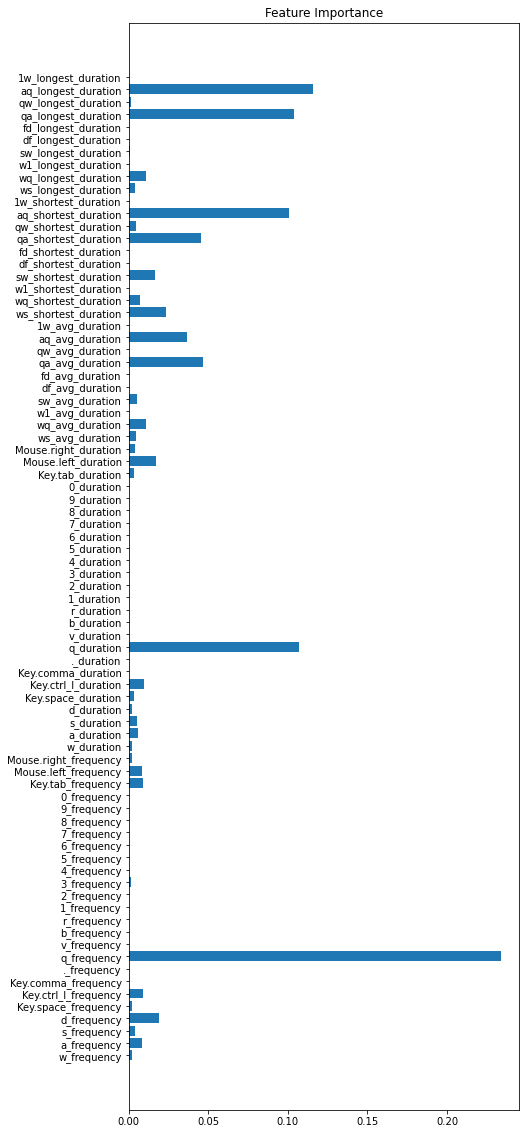

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = rfc.feature_importances_
#indices = np.argsort(importances)

# Expand figure vertically
plt.figure(figsize=(7,20))

# Barplot
plt.barh(range(len(importances)), importances)
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(importances)), KeyboardHeatmap.heatmap_data_names())
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(310.0, 543.6, 'ws_shortest_duration <= 0.11\ngini = 0.498\nsamples = 176\nvalue = [129, 147]'),
 Text(169.0909090909091, 422.8, 'aq_shortest_duration <= 0.056\ngini = 0.278\nsamples = 69\nvalue = [90, 18]'),
 Text(112.72727272727273, 302.0, 'q_frequency <= 0.05\ngini = 0.022\nsamples = 61\nvalue = [90, 1]'),
 Text(56.36363636363637, 181.2, 'gini = 0.0\nsamples = 60\nvalue = [90, 0]'),
 Text(169.0909090909091, 181.2, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(225.45454545454547, 302.0, 'gini = 0.0\nsamples = 8\nvalue = [0, 17]'),
 Text(450.90909090909093, 422.8, 'qa_longest_duration <= 0.064\ngini = 0.357\nsamples = 107\nvalue = [39, 129]'),
 Text(394.54545454545456, 302.0, 'Key.tab_frequency <= 0.008\ngini = 0.423\nsamples = 39\nvalue = [39, 17]'),
 Text(281.8181818181818, 181.2, 'a_frequency <= 0.542\ngini = 0.095\nsamples = 12\nvalue = [19, 1]'),
 Text(225.45454545454547, 60.39999999999998, 'gini = 0.0\nsamples = 11\nvalue = [19, 0]'),
 Text(338.1818181818182, 60.3999999

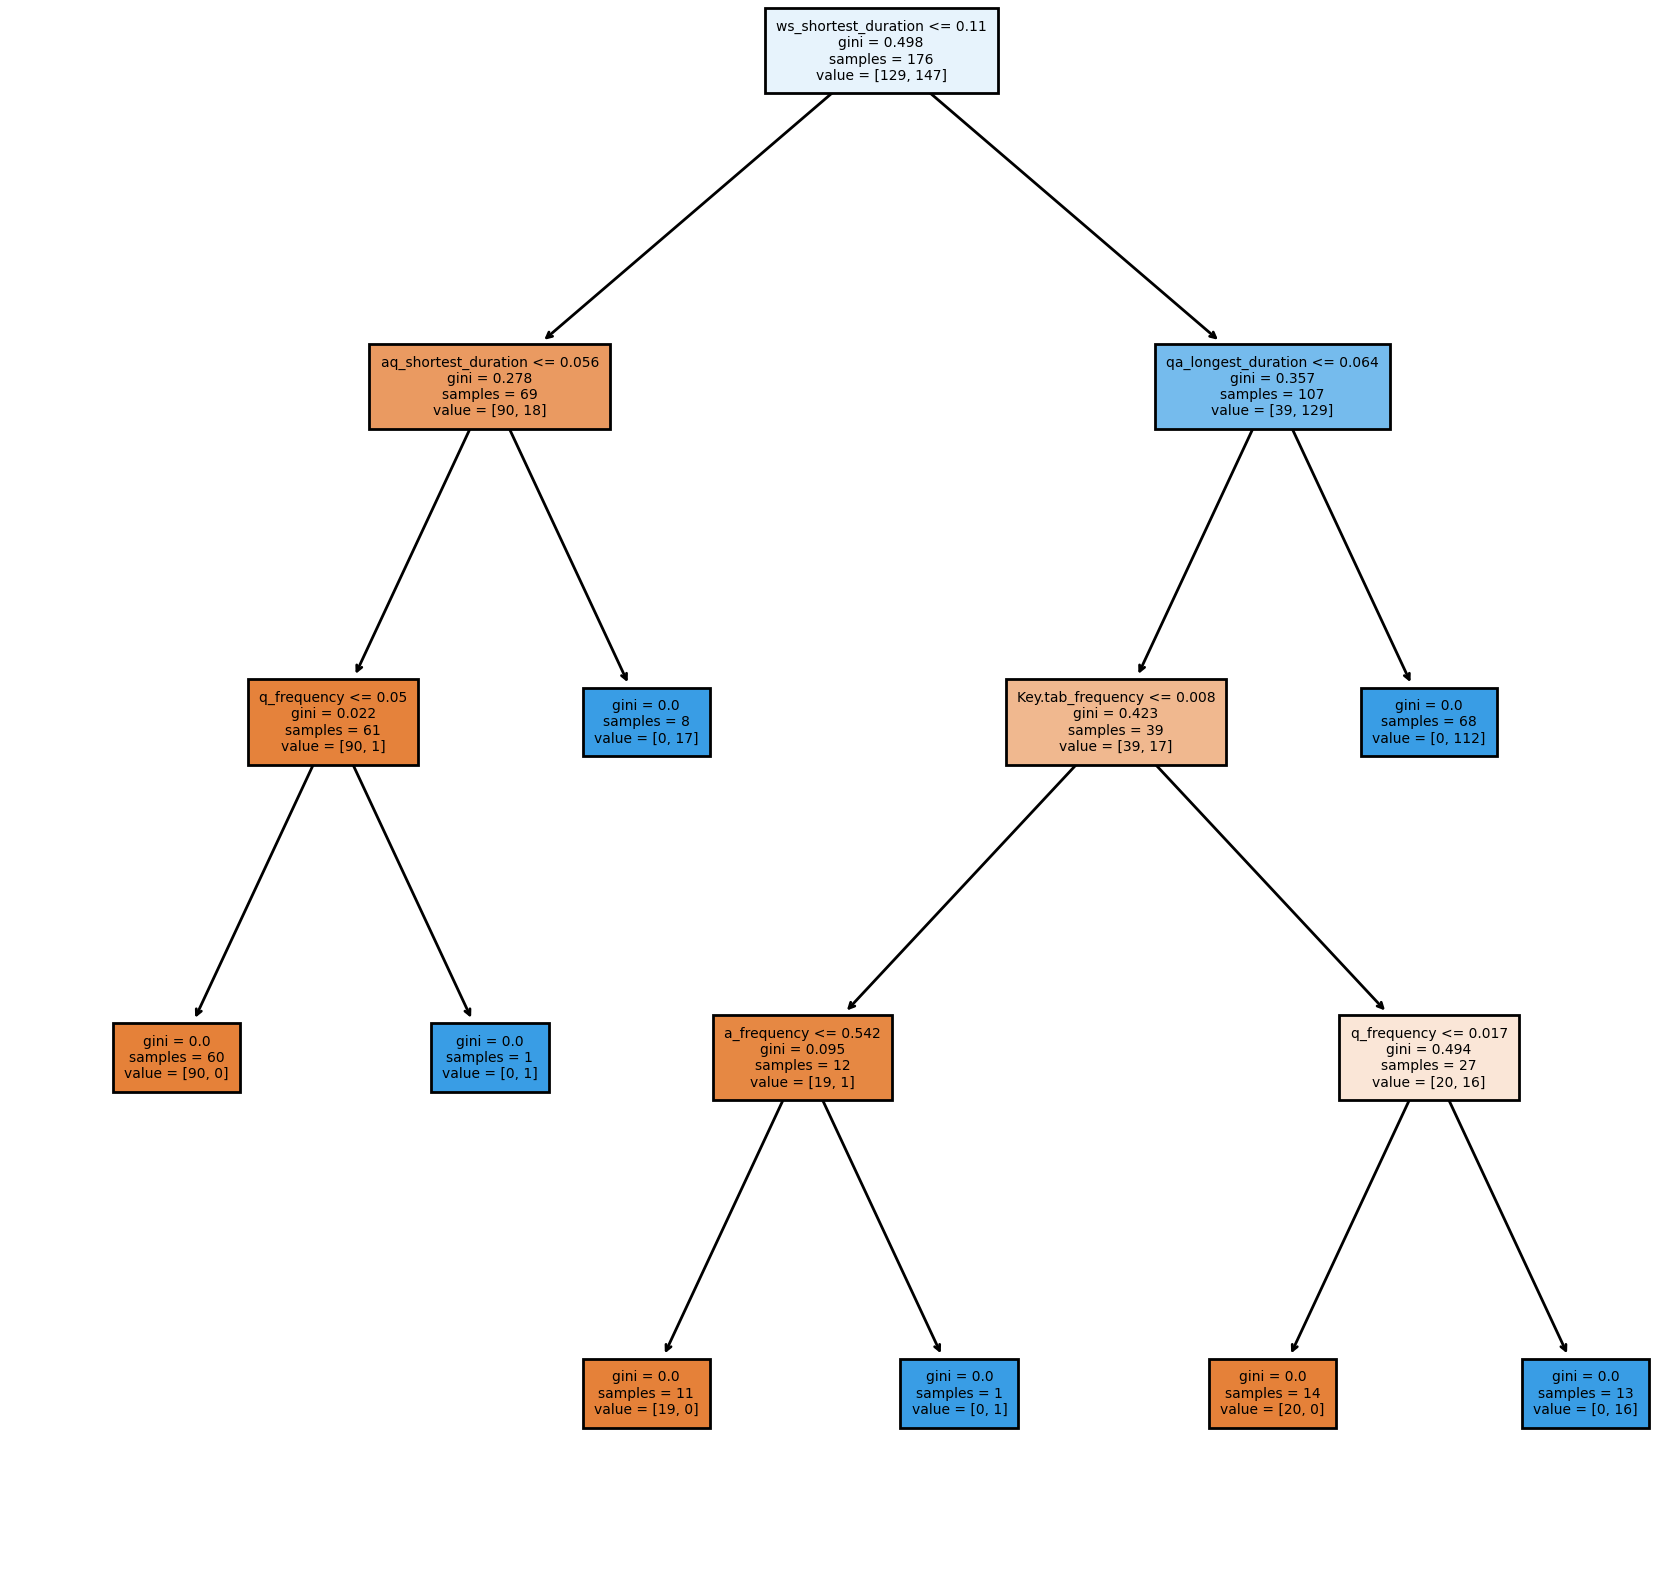

In [5]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], fontsize=5,feature_names = KeyboardHeatmap.heatmap_data_names(),filled = True)